In [11]:
import os
import matplotlib.pyplot as plt
from stompy import utils
import pandas as pd
import numpy as np
import xarray as xr
from stompy.grid import unstructured_grid
from stompy.model.fish_ptm import ptm_tools
%matplotlib notebook

In [100]:
import six
six.moves.reload_module(ptm_tools)

<module 'stompy.model.fish_ptm.ptm_tools' from '/home/rusty/src/stompy/stompy/model/fish_ptm/ptm_tools.py'>

In [94]:
ptm_run_dir="stormwater/"
hydro_file="/opt2/sfb_ocean/suntans/runs/merge_007-20170607/average.nc_0000.nc"
ptm_hydro_file="/opt2/sfb_ocean/suntans/runs/merge_007-20170607/ptm_hydro_0000.nc"

In [95]:
hydro=xr.open_dataset(hydro_file)
ptm_hydro=xr.open_dataset(ptm_hydro_file)
grid=unstructured_grid.UnstructuredGrid.from_ugrid(hydro)

In [96]:
hydro['Nkc']=hydro['Nk']
del hydro['Nk']

In [97]:
tidx=np.searchsorted(hydro.time.values, np.datetime64("2017-06-08 00:00"))
tidx

48

In [98]:
tidx=np.searchsorted(ptm_hydro.Mesh2_data_time.values, np.datetime64("2017-06-08 00:00"))
tidx

48

In [14]:
c=grid.select_cells_nearest([549482,4186876],inside=True)
c

33313

In [28]:
ptm_hydro.isel(nMesh2_data_time=tidx)

<xarray.Dataset>
Dimensions:                        (Two: 2, date_string_length: 19, nMaxMesh2_face_nodes: 8, nMesh2_edge: 108448, nMesh2_face: 57719, nMesh2_layer_3d: 50, nMesh2_node: 50711)
Coordinates:
    Mesh2_face_x                   (nMesh2_face) float64 ...
    Mesh2_face_y                   (nMesh2_face) float64 ...
    Mesh2_edge_x                   (nMesh2_edge) float64 ...
    Mesh2_edge_y                   (nMesh2_edge) float64 ...
Dimensions without coordinates: Two, date_string_length, nMaxMesh2_face_nodes, nMesh2_edge, nMesh2_face, nMesh2_layer_3d, nMesh2_node
Data variables:
    Mesh2_node_x                   (nMesh2_node) float64 ...
    Mesh2_node_y                   (nMesh2_node) float64 ...
    Mesh2_edge_bc                  (nMesh2_edge) float64 ...
    Mesh2_edge_nodes               (nMesh2_edge, Two) float64 ...
    Mesh2_edge_faces               (nMesh2_edge, Two) float64 ...
    Mesh2_face_nodes               (nMesh2_face, nMaxMesh2_face_nodes) float64 ...
   

<IPython.core.display.Javascript object>


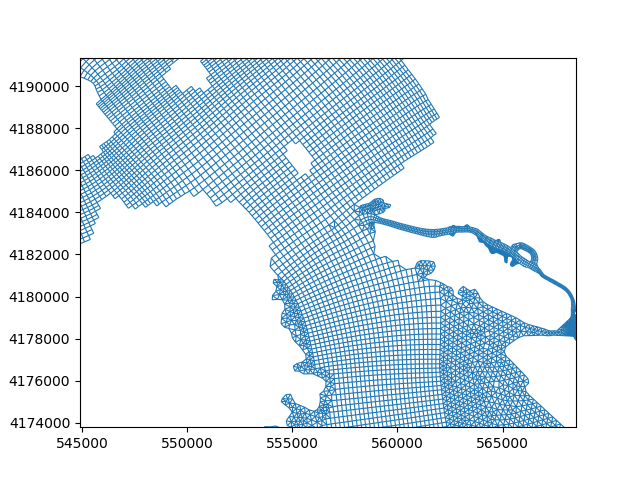

In [30]:
bin_file=ptm_tools.PtmBin(os.path.join(ptm_run_dir,'UP5mm_bin.out'))

In [31]:
bin_file.count_timesteps()

580

In [101]:
state=ptm_tools.PtmState(os.path.join(ptm_run_dir,"UPdebug_state.out"))

In [ ]:
plt.figure()
grid.plot_edges()

<IPython.core.display.Javascript object>


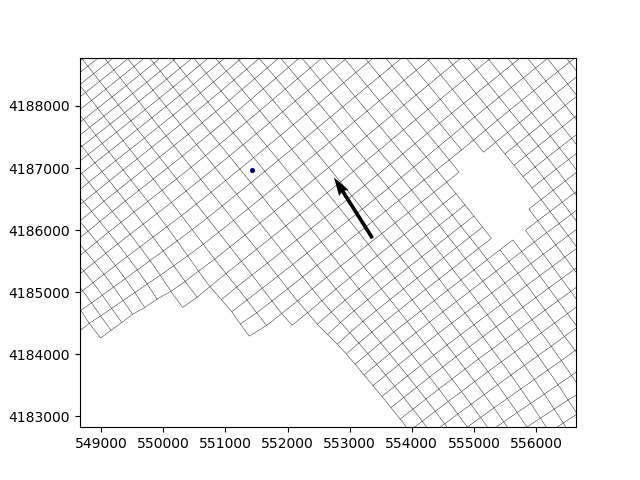

In [37]:
# zoom=(492273., 584318, 4157899., 4226487.)
#zoom=(543109., 549115., 4183563, 4188039.)
zoom=[548658., 556644., 4182827., 4188778]
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

grid.plot_edges(color='k',facecolor='0.7',lw=0.3,ax=ax,zorder=-2)

vel_points=np.array([[546265,4185860],
                     [553367,4185870]])
cells=[grid.select_cells_nearest(vel_pnt) for vel_pnt in vel_points]
          
          
ktop=3    
    
def set_timestep(i):
    dnum,particles=bin_file.read_timestep(i)
    ax.lines=[]
    del ax.collections[1:]
    sel=particles['id']>12849 # particles['x'][:,2]>-7 # only surface
    scal=particles['id']
    # scal=particles['x'][:,2]
    ax.scatter(particles['x'][sel,0],
               particles['x'][sel,1],
               7,scal[sel],cmap='jet')
    avg_idx=np.searchsorted(hydro.time,utils.to_dt64(dnum))
    U=hydro.uc.isel(Nk=ktop,Nc=cells,time=avg_idx)
    V=hydro.vc.isel(Nk=ktop,Nc=cells,time=avg_idx)
    quiv=ax.quiver(vel_points[:,0],vel_points[:,1],
                   U.values,V.values,
                   scale_units='xy',angles='xy',scale=0.0005,zorder=3)
ax.axis(zoom)
set_timestep(1)

In [54]:
import pandas as pd

360.0

In [106]:
part_step=5
dnum,particles=state.read_timestep(part_step)
print("Particle time:",dnum)

dnum2,particles2=state.read_timestep(part_step+1)
dt=(dnum2-dnum).total_seconds()


part_idx=1280 
x=particles['x'][part_idx,:]
dx=particles2['x'][part_idx] - particles['x'][part_idx]

part_vel=dx/dt

print("particle x:",x)
print("particle vel:",part_vel)
c=grid.select_cells_nearest(x,inside=True)
print("in cell:",c)

for name in particles.dtype.names:
    print("  %s: %s"%( name, particles[name][part_idx] ))
          

avg_tidx=np.searchsorted(ptm_hydro.Mesh2_data_time.values,
                         utils.to_dt64(dnum))
print("hydro time idx:",avg_tidx,ptm_hydro.Mesh2_data_time.values[avg_tidx])

df=pd.DataFrame()

uc=hydro.uc.isel(time=avg_tidx,Nc=c)
vc=hydro.vc.isel(time=avg_tidx,Nc=c)
df['uc']=uc.values[::-1]
df['vc']=vc.values[::-1]

ptm_cell=ptm_hydro.isel(nMesh2_data_time=avg_tidx,nMesh2_face=c)
print("eta from avg:",ptm_cell.Mesh2_sea_surface_elevation)
df['face_volume']=ptm_cell.Mesh2_face_water_volume

df['face_wet_area']=ptm_cell.Mesh2_face_wet_area.values
df['face_dz']=df.face_volume/df.face_wet_area

is_top=np.zeros(len(uc),np.bool8)
is_top[ptm_cell.Mesh2_face_top_layer.values.astype(np.int32)]=True
df['top_cell']=is_top
df    

Particle time: 2017-06-08 00:30:00
particle x: [ 5.51352052e+05  4.18706224e+06 -5.15298038e+00]
particle vel: [-0.01460058  0.03086431  0.00014619]
in cell: 33902
  id: 1281
  x: [ 5.51352052e+05  4.18706224e+06 -5.15298038e+00]
  status: 1
  u: [-0.29331315  0.35181186  0.0050128 ]
  salinity: 27.988934
  layer: 48.0
  water_depth: 19.666636
  water_level: -5.0924735
  bed_elevation: 24.75911
hydro time idx: 49 2017-06-08T00:30:00.000000000
eta from avg: <xarray.DataArray 'Mesh2_sea_surface_elevation' ()>
array(-5.145632)
Coordinates:
    Mesh2_face_x  float64 ...
    Mesh2_face_y  float64 ...
Attributes:
    long_name:  sea surface elevation
    units:      m


,uc,vc,face_volume,face_wet_area,face_dz,top_cell
0,NaN,NaN,0.000000,82254.21,0.000000,False
1,NaN,NaN,0.000000,82254.21,0.000000,False
2,NaN,NaN,0.000000,82254.21,0.000000,False
3,NaN,NaN,0.000000,82254.21,0.000000,False
4,NaN,NaN,0.000000,82254.21,0.000000,False
5,NaN,NaN,0.000000,82254.21,0.000000,False
6,NaN,NaN,0.000000,82254.21,0.000000,False
7,NaN,NaN,0.000000,82254.21,0.000000,False
8,NaN,NaN,0.000000,82254.21,0.000000,False
9,NaN,NaN,0.000000,82254.21,0.000000,False


In [92]:
# What do the edges say at this layer?
edgenorms=grid.edges_normals()

k=47 # 0-based, increasing upwards.
avg_vel=0.0
js=grid.cell_to_edges(c)
for j in js:
    print(j)
    ptm_edge=ptm_cell.isel(nMesh2_edge=j,nMesh2_layer_3d=k)
    this_vnorm=(ptm_edge.h_flow_avg/ptm_edge.Mesh2_edge_wet_area).values 
    avg_vel=avg_vel + 2./len(js) * this_vnorm*edgenorms[j]
    print(" area=%.2f h_flow=%.2f  vel=%.2f (%s)"%
          (ptm_edge.Mesh2_edge_wet_area,
           ptm_edge.h_flow_avg,
           this_vnorm,
          this_vnorm*edgenorms[j]))
print("cell-avg velocity:",avg_vel)

34136
 area=209.37 h_flow=4.20  vel=0.02 ([-0.01555929 -0.01264388])
34241
 area=212.22 h_flow=-90.86  vel=-0.43 ([-0.27078958  0.33164298])
34242
 area=210.01 h_flow=-1.65  vel=-0.01 ([0.00607446 0.00496167])
34137
 area=212.21 h_flow=-97.52  vel=-0.46 ([-0.29152465  0.3552259 ])
cell-avg velocity: [-0.28589954  0.33959334]


In [83]:
avg_vel

array([-0.00497571,  0.00606296])

In [51]:
ptm_hydro

<xarray.Dataset>
Dimensions:                        (Two: 2, date_string_length: 19, nMaxMesh2_face_nodes: 8, nMesh2_data_time: 479, nMesh2_edge: 108448, nMesh2_face: 57719, nMesh2_layer_3d: 50, nMesh2_node: 50711)
Coordinates:
    Mesh2_face_x                   (nMesh2_face) float64 ...
    Mesh2_face_y                   (nMesh2_face) float64 ...
    Mesh2_edge_x                   (nMesh2_edge) float64 ...
    Mesh2_edge_y                   (nMesh2_edge) float64 ...
Dimensions without coordinates: Two, date_string_length, nMaxMesh2_face_nodes, nMesh2_data_time, nMesh2_edge, nMesh2_face, nMesh2_layer_3d, nMesh2_node
Data variables:
    Mesh2_node_x                   (nMesh2_node) float64 ...
    Mesh2_node_y                   (nMesh2_node) float64 ...
    Mesh2_edge_bc                  (nMesh2_edge) float64 ...
    Mesh2_edge_nodes               (nMesh2_edge, Two) float64 ...
    Mesh2_edge_faces               (nMesh2_edge, Two) float64 ...
    Mesh2_face_nodes               (nMesh2_fa

In [110]:
for i in range(bin_file.count_timesteps()):
    set_timestep(i)
    fig.canvas.draw()
    plt.pause(0.1)
    

KeyboardInterrupt: 

In [109]:
ptm_hydro2_file="/opt2/sfb_ocean/suntans/runs/merge_007-20170607/ptm_hydro_0001.nc"
ptm_hydro2=xr.open_dataset(ptm_hydro2_file)

In [113]:
# ptm output is *missing* 23:30
ptm_hydro.Mesh2_data_time[-2:], ptm_hydro2.Mesh2_data_time[:2]

(<xarray.DataArray 'Mesh2_data_time' (nMesh2_data_time: 2)>
 array(['2017-06-16T22:30:00.000000000', '2017-06-16T23:00:00.000000000'],
       dtype='datetime64[ns]')
 Dimensions without coordinates: nMesh2_data_time,
 <xarray.DataArray 'Mesh2_data_time' (nMesh2_data_time: 2)>
 array(['2017-06-17T00:00:00.000000000', '2017-06-17T00:30:00.000000000'],
       dtype='datetime64[ns]')
 Dimensions without coordinates: nMesh2_data_time)

In [114]:
hydro2_file="/opt2/sfb_ocean/suntans/runs/merge_007-20170607/average.nc_0000.nc"
hydro2=xr.open_dataset(hydro2_file)

<xarray.DataArray 'time' (time: 480)>
array(['2017-06-07T00:00:00.000000000', '2017-06-07T00:30:00.000000000',
       '2017-06-07T01:00:00.000000000', ..., '2017-06-16T22:30:00.000000000',
       '2017-06-16T23:00:00.000000000', '2017-06-16T23:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-06-07 ... 2017-06-16T23:30:00
Attributes:
    long_name:  time

In [115]:
# average output has it, though.
# BUT - U_F is nan for first two timesteps, but has flux through the end.

hydro.time[-2:],hydro2.time[:2]

(<xarray.DataArray 'time' (time: 2)>
 array(['2017-06-16T23:00:00.000000000', '2017-06-16T23:30:00.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
   * time     (time) datetime64[ns] 2017-06-16T23:00:00 2017-06-16T23:30:00
 Attributes:
     long_name:  time, <xarray.DataArray 'time' (time: 2)>
 array(['2017-06-07T00:00:00.000000000', '2017-06-07T00:30:00.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
   * time     (time) datetime64[ns] 2017-06-07 2017-06-07T00:30:00
 Attributes:
     long_name:  time)

In [122]:
j=grid.select_edges_nearest([547473,4.18618e6])
j

31351

In [124]:
U_Fj=hydro.U_F.isel(Ne=j).values

<IPython.core.display.Javascript object>


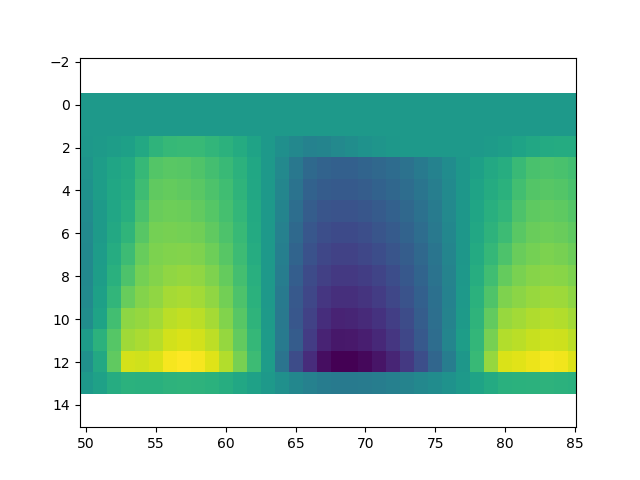

In [127]:
plt.figure()
plt.imshow(U_Fj.T,aspect='auto')

In [129]:
U_Fj[-2:]

array([[  0.        ,   0.        , 184.41615766, 344.54399271,
        373.12827619, 405.48316163, 430.53617971, 445.34858318,
        466.99454167, 502.81763168, 549.32626846, 603.49902824,
        688.55384393, 165.98622196,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [  0.        ,   0.        , 180.90414434, 314.13190481,
        342.9600475 , 370.34130904, 392.8578052 , 421.0352229 ,
        459.16984356, 505.25451836, 557.97882511, 616.64165798,
   

In [133]:
ptm_hydro2.h_flow_avg.isel(nMesh2_data_time=0,nMesh2_edge=j)

<xarray.DataArray 'h_flow_avg' (nMesh2_layer_3d: 50)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, -164.830611, -681.006842, -593.573165, -534.63116 ,
       -481.071833, -433.220888, -391.199484, -355.426082, -324.946886,
       -294.82378 , -264.587347, -158.536309,   -0.      ,   -0.      ])
Coordinates:
    Mesh2_edge_x  float64 ...
    Mesh2_edge_y  float64 ...
Dimensions without coordinates: nMesh2_layer_3d
Attributes:
    long_name:    Horizontal volume flux averaged over integration interval
    units:      

In [137]:
ls stormwater

central_bay.pol            FISH_PTM_bathymetry_check.log
DOWN5mm_avg_conc.out       FISH_PTM.grd_geom
DOWN5mm_avg_region.out     FISH_PTM.grd_log
DOWN5mm_bin.idx            FISH_PTM_hydrodynamics.inp
DOWN5mm_bin.out            FISH_PTM_hydrodynamics.inp~
DOWN5mm_day_region.out     FISH_PTM.inp
DOWN5mm_deposited.out      FISH_PTM.inp~
DOWN5mm_flag.log           FISH_PTM_input_checking.log
DOWN5mm_ins_conc.out       FISH_PTM_input.log
DOWN5mm_kill.log           FISH_PTM.met
down_5mm_per_s.inp         FISH_PTM_method.inp
down_5mm_per_s.inp~        FISH_PTM_method.inp~
DOWN5mm.reg_release_log    fort.333444
DOWN5mm.release_log        log
DOWN5mm_xstats_ts.txt      passive.inp
DOWN5mm_xstats.txt         ptm_release_log.prn
DOWN5mm_ystats_ts.txt      swim_down_5mm_per_s_profile.inp
DOWN5mm_ystats.txt         swim_up_5mm_per_s_profile.inp
DOWN5mm_zstats_ts.txt      swim_up_5mm_per_s_profile.inp~
DOWN5mm_zstats.txt         UP5mm_avg_conc.out
DOWNdebug_avg_conc.out     UP5mm_avg_region.out
DOWN

In [138]:
down=ptm_tools.PtmState('stormwater/DOWNdebug_state.out')

In [158]:
part_tidx=100
dt,particles=down.read_timestep(part_tidx)
part_time=utils.to_dt64(dt)
dt2,particles2=down.read_timestep(part_tidx+1)

print(part_time)

len(particles) # 1312
idx=1000
for name in particles.dtype.names: 
    print("%s: %s"%(name,particles[name][idx]))
    
hab=particles['x'][idx,2]+particles['bed_elevation'][idx]
print("height above bed: ",hab)

dt_secs=(dt2-dt).total_seconds()
part_vel=(particles2['x'][idx] - particles['x'][idx])/dt_secs
print("velocity over %.1fs: %s"%(dt_secs,part_vel))

2017-06-14T10:00:00.000000
id: 1001
x: [ 5.50538733e+05  4.18792560e+06 -4.22997020e+01]
status: 1
u: [0. 0. 0.]
salinity: 30.23336
layer: 38.0
water_depth: 38.182938
water_level: -4.365792
bed_elevation: 42.54873
height above bed:  0.2490269118384134
velocity over 360.0s: [ 0.00000000e+00  0.00000000e+00 -1.87539472e-05]


In [161]:
tidx=np.searchsorted(hydro.time.values,part_time)
print("hydro time: ",hydro.time.values[tidx])

part_cell=grid.select_cells_nearest(particles['x'][idx,:2])
print(" in cell: ",part_cell)

u=hydro.uc.isel(time=tidx,Nc=part_cell)
print(u.values)
u.values[12] # really is 0.0 in the hydro.

hydro time:  2017-06-14T10:00:00.000000000
 in cell:  33199
[ 0.          0.         -0.23126227 -0.11857591  0.11184202  0.26776569
  0.356118    0.41547428  0.43799393  0.43876242  0.43542623  0.2586364
  0.                 nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan]


0.0

In [167]:
print("Cell layers: ",hydro.Nkc.isel(Nc=part_cell).values)

for j in grid.cell_to_edges(part_cell):
    print(" edge j=%d Nke=%d"%(j,hydro.Nke.isel(Ne=j).values))


Cell layers:  13
 edge j=33487 Nke=12
 edge j=33605 Nke=12
 edge j=33606 Nke=12
 edge j=33488 Nke=12


In [163]:
hydro

<xarray.Dataset>
Dimensions:       (Nc: 57719, Ne: 108448, Nk: 50, Nkw: 51, Np: 50711, Two: 2, numsides: 8, time: 480)
Coordinates:
    xv            (Nc) float64 5.809e+05 5.827e+05 ... 5.295e+05 5.298e+05
    yv            (Nc) float64 4.151e+06 4.152e+06 ... 4.176e+06 4.176e+06
    xe            (Ne) float64 ...
    ye            (Ne) float64 ...
    z_r           (Nk) float64 ...
    z_w           (Nkw) float64 ...
  * time          (time) datetime64[ns] 2017-06-07 ... 2017-06-16T23:30:00
Dimensions without coordinates: Nc, Ne, Nk, Nkw, Np, Two, numsides
Data variables:
    suntans_mesh  int32 ...
    cells         (Nc, numsides) int32 0 11345 358 ... 999999 999999 999999
    nfaces        (Nc) int32 ...
    face          (Nc, numsides) int32 ...
    edges         (Ne, Two) int32 5057 5058 5053 5057 ... 50664 50705 50664
    neigh         (Nc, numsides) int32 ...
    grad          (Ne, Two) int32 ...
    xp            (Np) float64 5.809e+05 5.825e+05 ... 5.283e+05 5.293e+05
    yp 